# Search For Efficient Defense Mechanism Against $l_0$ -norm Bound Attacks




**Eric Yoon**, University of California - Santa Barbara, changhee@ucsb.edu



---



# **Abstract**

Adversarial attacks pose significant challenges to the robustness and reliability of deep learning models. This project investigates a defense mechanism against $l_0$ norm bound adversarial attacks in the context of text classifiers, inspired by the [truncation method](https://arxiv.org/abs/2201.09369) used in computer vision and guaranteed robustness from input augmentation with [random masking](https://arxiv.org/abs/2105.03743). The primary goal of this project was to develop a method for efficiently detecting perturbed words in input sentences with high accuracy, consequently masking them to enhance the robustness of text classifier models. We explored various approaches to measure word importance, including frequency-based importance scales such as TF-IDF and vulnerability-based measures. Despite our efforts, the proposed methods did not yield satisfactory results in defending against adversarial attacks. Though implementing the attack mechanism to mask words did make the model more computationally intensive to generate successful attacks. This paper presents an overview of the conducted research, the methodologies employed, and a discussion on potential improvements for future investigations.



# **Introduction**

In the image domain, truncation has proven to be an efficient and robust defense against $l_0$-bound adversarial attacks. This method involves computing the k-truncated inner product of two vectors, w (trainable weight) and x (input), by removing the top and bottom k elements after calculating the element-wise product. Motivated by the effectiveness of truncation technique in the image domain, we sought to adapt this method to the natural language processing (NLP) domain, specifically for deep-learning based text classifier models, in order to develop a similar defense mechanism against $l_0$-bound adversarial attacks.

In the NLP domain,  $l_0$-bound attacks seek to minimally alter the input text's words or characters to manipulate the model's behavior. Text classifiers face attacks like BERT Attack and TextFooler, which identify important words in a sentence and replace them with semantically similar alternatives, making the perturbations imperceptible to humans while altering the model's output (wrong classification).




For another reference for this project, [Randomized [MASK]](https://arxiv.org/abs/2105.03743) is an efficient and robust mechanism to defend agaist adversarial attacks for text classifiers. RanMASK enhances the model's robustness by randomly masking words, generating multiple augmented sentences, obtaining predictions for each, and using a voting system to arrive at the final prediction. This method effectively defends against both word substitution-based and character-level adversarial attacks. 




Drawing inspiration from both Truncation and Randomized [MASK] methods, we sought to devise a strategy for masking a specific percentage of words in an input sentence non-randomly, using an efficient algorithm, to enhance robustness against adversarial attacks.


To develop the masking algorithm against importance-based synonym replacement attacks, we explored methods for ranking words in an input sentence or vectorized tokens (processed using a pre-trained tokenizer) by importance.

We experimented with two approaches:

- Method 1: TF-IDF - a normalized frequency-based method to measure word importance.

- Method 2: Vulnerability - finding which words are the most likely to be perturbed using the same algorithm used in attack mechanisms.

# **Methods and Experiements**

The target model used for experiements was a [RoBERTa](https://arxiv.org/abs/1907.11692) based classifier trained on [AGNEWS dataset](https://huggingface.co/datasets/ag_news). RoBERTa is an optimized BERT-based language model, utilizing byte-pair encoding tokenizer, dynamic masking, larger batches, and extended training for improved performance.

The pre-trained RoBERTa based classifier [model](https://huggingface.co/textattack/roberta-base-ag-news) and the AGNEWS dataset were both loaded from HuggingFace for the experiments.

For simulating attacks and testing the robustness of different methods, [TextAttack](https://textattack.readthedocs.io/en/latest/index.html) framework was used. For testing each method, the algorithm was implemented in a custom model wrapper class, a modified [HuggingFaceModelWrapper](https://textattack.readthedocs.io/en/latest/_modules/textattack/models/wrappers/huggingface_model_wrapper.html), to be used with TextAttack's attack API. 

For the attack recipes, [TextFoolerJin2019](https://textattack.readthedocs.io/en/latest/_modules/textattack/attack_recipes/textfooler_jin_2019.html) and [bert_attack_li_2020](https://textattack.readthedocs.io/en/latest/_modules/textattack/attack_recipes/bert_attack_li_2020.html) were used to simulate the model's performance against importance based synonym replacement attacks.

For both methods, we measured these metrics:
- Model's accuracy without attack
- Model's accuracy under attack, with perturbed inputs
- Number of queries/iterations required for successful attacks

## Method 1 - Frequency Based Masking: masking words with the highest TF-IDF values

Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure for evaluating the importance of a word in a document or a corpus of documents. It's quite commonly used for various NLP tasks such as document similarity analysis, text mining, and Naive Bayes text classifier.



Here's the formula for TF-IDF:

t — term (word)

d — document (set of words)

N — count of corpus

corpus — the total document set (list of input sentences)

tf(t,d) = count of t in d / number of words in d

df(t) = occurrence of t in N documents

idf(t) = $log(\frac{N}{\textrm{df}(t)+1})$

tf-idf(t,d) = tf(t,d)*idf(t)

**tf-idf(t,d) = $\textrm{tf}(t,d) * log(\frac{N}{\textrm{df}(t)+1})$**

TF-IDF is essentially a normalized frequency count




In this method, we used the training dataset to make a vocab with TF-IDF values of each unique word. Then the vocab was used in the model to sort the words and mask top n% words according to the TF-IDF values.



As stop words such as "a", "the", "and" appear very frequently but aren't used to contain specific semantic content, TF-IDF values for stop words were set to zero, so we can mask the most important words that contain specific semantic content.



In addition to the TF-IDF based word masking, we also experimented with masking vectorized tokens (using pre-trained RoBERTa tokenizer) based on the TF-IDF values of each tokens in the training set.



Below is the model wrapper class with the mechanism implmented.

#### MyWrapperImportanceBasedMask:

In [ ]:
class MyWrapperImportanceBasedMask(PyTorchModelWrapper):
    """Loads a HuggingFace ``transformers`` model and tokenizer."""

    def __init__(self, model, tokenizer, importance_dict):
        assert isinstance(
            model, (transformers.PreTrainedModel, T5ForTextToText)
        ), f"`model` must be of type `transformers.PreTrainedModel`, but got type {type(model)}."
        assert isinstance(
            tokenizer,
            (
                transformers.PreTrainedTokenizer,
                transformers.PreTrainedTokenizerFast,
                T5Tokenizer,
            ),
        ), f"`tokenizer` must of type `transformers.PreTrainedTokenizer` or `transformers.PreTrainedTokenizerFast`, but got type {type(tokenizer)}."

        self.model = model
        self.tokenizer = tokenizer
        self.importance_dict = importance_dict

    def __call__(self, text_input_list):
        """Passes inputs to HuggingFace models as keyword arguments.
        (Regular PyTorch ``nn.Module`` models typically take inputs as
        positional arguments.)
        """
#############################       
        percent_to_mask = 30
        for i in range(len(text_input_list)):
            # truncate n% of words using tfidf
            words = text_input_list[i].split()

            # Sort the words in descending order of importance
            sorted_words = sorted(words, key=lambda w: self.importance_dict.get(w, 0), reverse=True)

            # Replace the n most important words with "<mask>"
            n_words_to_mask = int(len(sorted_words) * (int(percent_to_mask) / 100))
            masked_words = ["<mask>" if w in sorted_words[:n_words_to_mask] else w for w in words]

            # Join the remaining words back into a sentence
            remaining_sentence = " ".join(masked_words)

            text_input_list[i] = remaining_sentence
#############################

        # Default max length is set to be int(1e30), so we force 512 to enable batching.
        max_length = (
            512
            if self.tokenizer.model_max_length == int(1e30)
            else self.tokenizer.model_max_length
        )
        inputs_dict = self.tokenizer(
            text_input_list,
            add_special_tokens=True,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )

        model_device = next(self.model.parameters()).device
        inputs_dict.to(model_device)

        with torch.no_grad():
            outputs = self.model(**inputs_dict)

        if isinstance(outputs[0], str):
            # HuggingFace sequence-to-sequence models return a list of
            # string predictions as output. In this case, return the full
            # list of outputs.
            return outputs
        else:
            # HuggingFace classification models return a tuple as output
            # where the first item in the tuple corresponds to the list of
            # scores for each input.
            return outputs.logits

Below is the function used to create TF-IDF vocab

In [ ]:
from collections import Counter
from nltk.stem import WordNetLemmatizer

def tfidf_vocab(sentences):
    # lemmatizer = WordNetLemmatizer()

    # Step 1: Calculate the term frequency (TF) for each word in each sentence
    tf_dict = {}
    sentence_count = len(sentences)
    for i, sentence in enumerate(sentences):
        words = sentence.split()
        word_count = len(words)
        word_freq = Counter(words)
        for word in word_freq:
            tf = word_freq[word] / word_count
            if word in tf_dict:
                if i in tf_dict[word]:
                    tf_dict[word][i] += tf
                else:
                    tf_dict[word][i] = tf
            else:
                tf_dict[word] = {i: tf}
    
    # Step 2: Calculate the inverse document frequency (IDF) for each word
    idf_dict = {}
    for word in tf_dict:
        idf_dict[word] = math.log(sentence_count / len(tf_dict[word]))
    
    # Step 3: Calculate the TF-IDF score for each word in each sentence
    tfidf_dict = {}
    for word in tf_dict:
        for sentence_index in tf_dict[word]:
            tf = tf_dict[word][sentence_index]
            idf = idf_dict[word]
            tfidf = tf * idf
            if sentence_index in tfidf_dict:
                tfidf_dict[sentence_index][word] = tfidf
            else:
                tfidf_dict[sentence_index] = {word: tfidf}
    
    # Step 4: Sum up TF-IDF scores for each unique word
    tfidf_corpus = {}
    for i in range(len(tfidf_dict)):
        for word in tfidf_dict[i]:
            if word in tfidf_corpus:
                tfidf_corpus[word] += tfidf_dict[i][word]
            else:
                tfidf_corpus[word] = tfidf_dict[i][word]
 
    return tfidf_corpus

## Method 2 - Masking Vulnerable Words: masking words with attack mechanism

Many word level adversarial attacks search for the most important words in the input to perturb in order to maximize the effect of the perturbation. BERT Attack in particular measures vulnerability of each word in an input sentence by:

1. augment the sentence by creating all variations of sentence with one word masked. 

For example, for a sentence "this is how a sentence is augmented":
    
    "<mask> is how a sentence is augmented"
    "this <mask> how a sentence is augmented"
    "this is <mask> a sentence is augmented"
    "this is how <mask> sentence is augmented"
    "this is how a <mask> is augmented"
    "this is how a sentence <mask> augmented"
    "this is how a sentence is <mask>"

2. run each sentence through the target model and collect the logit output from the model

3. The euclidean distance or cosine similarity between the logit output of the orginal sentence and the masked sentence is used to measure how much each word alters the output (vulnerability measure).

4. The most vulnerable words are ranked by the words with highest difference value.

In this method, the same mechanism was implemented to mask n% of words with the highest vulnerability score.


Additionally, similar to method 1 and the [implmentation of BERT Attack](https://github.com/LinyangLee/BERT-Attack/blob/master/bertattack.py), a word bank was also employeed to exclude stop words from being masked.

Below is the model wrapper implementation of the mechanism

#### MyWrapperVulnerableWordMask

In [ ]:
class MyWrapperVulnerableWordMask(PyTorchModelWrapper):
    """Loads a HuggingFace ``transformers`` model and tokenizer."""

    def __init__(self, model, tokenizer):
        assert isinstance(
            model, (transformers.PreTrainedModel, T5ForTextToText)
        ), f"`model` must be of type `transformers.PreTrainedModel`, but got type {type(model)}."
        assert isinstance(
            tokenizer,
            (
                transformers.PreTrainedTokenizer,
                transformers.PreTrainedTokenizerFast,
                T5Tokenizer,
            ),
        ), f"`tokenizer` must of type `transformers.PreTrainedTokenizer` or `transformers.PreTrainedTokenizerFast`, but got type {type(tokenizer)}."

        self.model = model
        self.tokenizer = tokenizer
        # self.tfidf_vocab = tfidf_vocab

    def __call__(self, text_input_list):
        """Passes inputs to HuggingFace models as keyword arguments.
        (Regular PyTorch ``nn.Module`` models typically take inputs as
        positional arguments.)
        """
        model_device = next(self.model.parameters()).device
#############################
        # from BERT attack github
        filter_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost',
                        'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another',
                        'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as',
                        'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides',
                        'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn',
                        "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere',
                        'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'first', 'for',
                        'former', 'formerly', 'from', 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'he', 'hence',
                        'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his',
                        'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's",
                        'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn',
                        "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly', 'must', 'mustn', "mustn't", 'my', 'myself',
                        'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none',
                        'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only',
                        'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per',
                        'please', 's', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow',
                        'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
                        'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein',
                        'thereupon', 'these', 'they', 'this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too',
                        'toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used', 've', 'was', 'wasn', "wasn't",
                        'we', 'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where',
                        'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while',
                        'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won',
                        "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've",
                        'your', 'yours', 'yourself', 'yourselves']
       
        percent_to_mask = 20
        for i in range(len(text_input_list)):
            sentence = text_input_list[i]
            words = sentence.split()
            combinations = []
            for j in range(len(words)):
                masked_sentence = " ".join(["<mask>" if k == j else words[k] for k in range(len(words))])
                combinations.append(masked_sentence)
            
            scores = []
            with torch.no_grad():
                original_logit = self.model(**self.tokenizer(sentence, add_special_tokens=True, max_length=128, padding=True, truncation=True, return_tensors="pt").to(model_device))[0]
            for combination in combinations:
                with torch.no_grad():
                    logit = self.model(**self.tokenizer(combination, add_special_tokens=True, max_length=128, padding=True, truncation=True, return_tensors="pt").to(model_device))[0]
                    # get the euclidean distance between original logit and the result
                    score = torch.dist(original_logit, logit)
                scores.append(score)
            
            # make a tuple of words : importance scores
            word_importance = [(word, score) for word, score in zip(words, scores)]

            # get the n most important words
            filtered_list = [pair for pair in word_importance if pair[0] not in filter_words]
    
            sorted_list = sorted(filtered_list, key=lambda x: x[1], reverse=True)
                        
            num_to_mask = int(len(words) * percent_to_mask / 100)

            top_n_words = [word for word, _ in sorted_list[:num_to_mask]]

            # top_words = sorted(word_importance, key=lambda x: x[1], reverse=True)[:num_to_mask]

            # replace the n most important words with "<mask>"
            text_input_list[i] = " ".join(["<mask>" if word in [x[0] for x in top_n_words] else word for word in words])

#############################
        # Default max length is set to be int(1e30), so we force 512 to enable batching.
        max_length = (
            512
            if self.tokenizer.model_max_length == int(1e30)
            else self.tokenizer.model_max_length
        )
        inputs_dict = self.tokenizer(
            text_input_list,
            add_special_tokens=True,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )

       
        
        inputs_dict.to(model_device)

        with torch.no_grad():
            outputs = self.model(**inputs_dict)

        if isinstance(outputs[0], str):
            # HuggingFace sequence-to-sequence models return a list of
            # string predictions as output. In this case, return the full
            # list of outputs.
            return outputs
        else:
            # HuggingFace classification models return a tuple as output
            # where the first item in the tuple corresponds to the list of
            # scores for each input.
            return outputs.logits

# **Results**

Before discussing the performance of the model with method 1 and 2, 

- the original target model's accuracy on the test set of AGNEWS dataset was 94.697%
- accuracy under TextFooler was 15.8%
- accuracy under BERT Attack was 26.7%
- TextFooler's attack success rate was 83.2%
- BERT Attack's attackk success rate was 71.8%

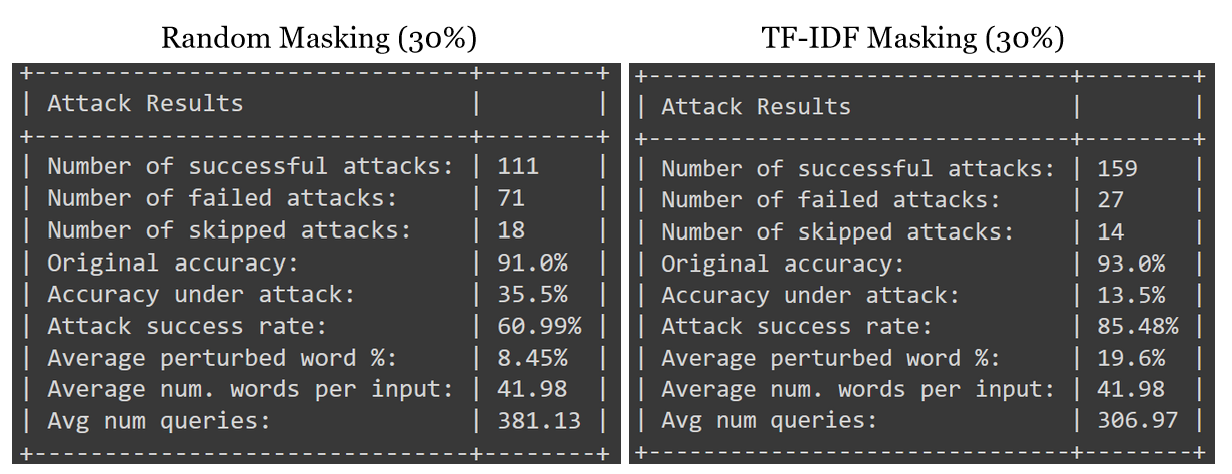

Figure above shows the measured performance of a model with 30% random masking (left) and a model with 30% TF-IDF masking (right) under TextFooler attack (200 samples). The average perturbed word percent on the raw model was about 30%, so 30% was chosen for masking.
Overall, TF-IDF based masking, method 1, resulted worse performance compared to random masking. 

Unfortunately, masking words based on its TF-IDF values appear to make the model easier to be fooled, making it less robust.

It's also noted that the average number of queries required to generate successful adversarial example was also lower than random masking - further confirming that method 1 results a less robust model.

Method 1 for masking vectorized tokens instead of words was also tested, but the result was very similar to the method 1 with masking words.

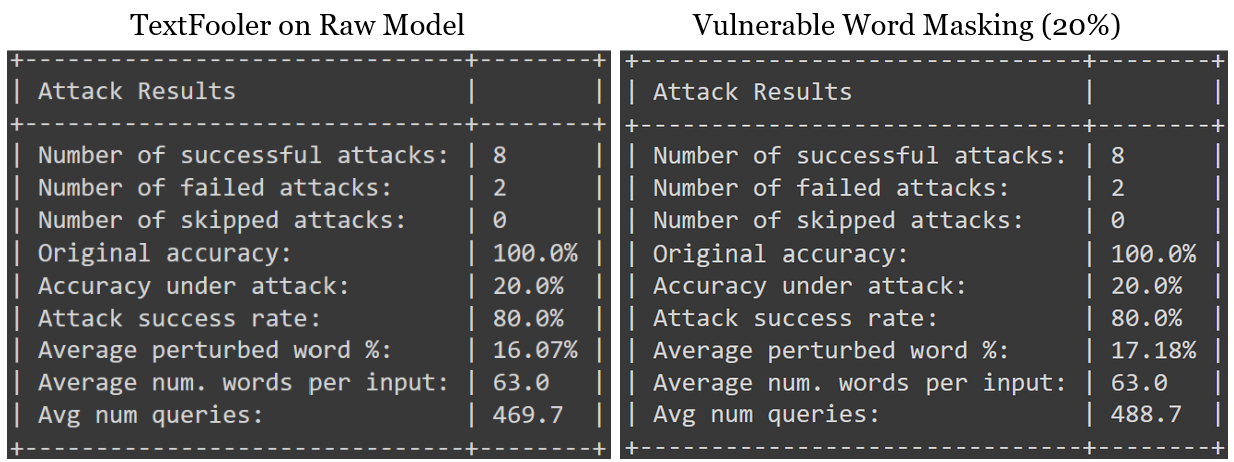

Above figure shows the performance of the raw model under TextFooler attack (left) and the performance of method 2 with 20% masking under TextFooler attack. 

Although the model's accuracy under attack was not improved, the average number of queries and average perturbed word % were higher when method 2 was implemented. It appears that method 2 makes the model little more computationally intensive to generate successful adversarial texts. When running the experiement, much longer run time was also observed.



For the performance under BERT attack, the increase in average number of queries required for successful attack was even higher.
For the 6 examples we were able to simulate, on the raw model, the average number of queries was 347 and on the model with method 2 was 445.2.

Additionally, to see if method 2 can actually identify the perturbed words, the change in word vulnerability ranking was compared before and after the perturbation:

First, the average ratio of words with the exact same rank before and after the perturbation was measured

- TextFooler: 6.3%
- BERT Attack: 6.6%

Then the number of sentences where the top 3 vulnerable words in the original sentence is still within the top 6 vulnerable words after the perturbation were counted. It was to see if important words stay relatively important after the perterbation, so the model can mask the perturbed words.

Result using 100 samples and 6 samples respectively: 
- TextFooler: 2%
- BERT Attack: 0%

This shows that method 2 doesn't do a great job at identifying the perturbed words since the the perturbations also change the word's importance most of the time.

# **Conclusion**

In conclusion, this project found that masking the top n important words as a defense mechanism does not provide adequate protection against importance-based adversarial attacks, such as TextFooler and BERT Attack. It appears that the method fails to deliver the desired results primarily due to the inherent adaptability of adversarial attacks. When the most important words are masked, attackers can simply shift their focus to the next most vulnerable words, exploiting the model's weaknesses and continuing to create effective perturbations. Using the attack's mechanism to mask important words require more computational power for the attcker to generate successful perturbations, but this method alone doesn't appear to successfully improve the model's accuracy under attack. 

